# Processamento de Dados
Este notebook pertence ao projeto: Case Téc­ni­co Data Sci­en­ce - iFo­od acessível em \
https://github.com/paulolaque/ifood-case.git

## Procedimentos iniciais

### Importação de bibliotecas

In [1]:
import os
import tarfile
import urllib.request
import sys



# Este notebook executa em pyspark, favor instalar caso necessário
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import (
    col,
    when,
    lit,
    explode,
    collect_set,
    collect_list,
    array,
    array_contains,
    sum as spark_sum,
    isnan,
    to_date,
    datediff,
    max as spark_max,
    year,
    month,
    weekofyear,
    struct
)
except ImportError:
    print("PySpark não está instalado. Instale com: pip install pyspark")
    sys.exit(1)

### Configuração de diretórios

In [2]:
# Detectar se está rodando no Databricks, pois o padrão de diretórios podem ser diferentes de uma máquina local
running_in_databricks = os.path.exists("/databricks/driver")

# Ajusta o caminho raiz do projeto
if running_in_databricks:
    project_root = "/dbfs" + os.getcwd().split("/notebooks")[0]  # raiz do workspace em DBFSpara Databricks
else:
    project_root = os.path.abspath("..")  # pasta acima de notebooks/

# Cria string de diretório
raw_data_path = os.path.join(project_root, "data", "raw")
tar_gz_path = os.path.join(raw_data_path, "ds-technical-evaluation-data.tar.gz")

# Cria a pasta se não existir
os.makedirs(raw_data_path, exist_ok=True)

### Configuração de sessão Spark 

In [3]:
# Cria SparkSession se necessário
spark = SparkSession.builder \
    .appName("Load JSON Files") \
    .getOrCreate()

25/04/17 18:44:34 WARN Utils: Your hostname, codespaces-257223 resolves to a loopback address: 127.0.0.1; using 10.0.3.150 instead (on interface eth0)
25/04/17 18:44:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 18:44:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Carregamento e Leitura dos Dados

### Download e extração de arquivos

In [4]:

# URL de download
url = "https://data-architect-test-source.s3.sa-east-1.amazonaws.com/ds-technical-evaluation-data.tar.gz"

# Baixa o arquivo se não existir
if not os.path.exists(tar_gz_path):
    print("Baixando arquivo...")
    urllib.request.urlretrieve(url, tar_gz_path)
    print("Download completo.")
else:
    print("Arquivo já existe.")

# Extrai os arquivos
print("Extraindo arquivos...")
with tarfile.open(tar_gz_path, "r:gz") as tar:
    tar.extractall(path=raw_data_path)
print("Extração completa.")

# Lista arquivos
extracted_path = os.path.join(raw_data_path, "ds-technical-evaluation-data")
print("Arquivos extraídos:")
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        print(os.path.join(root, file))

Arquivo já existe.
Extraindo arquivos...
Extração completa.
Arquivos extraídos:
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._transactions.json
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._offers.json
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/profile.json
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/offers.json
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._profile.json
/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/transactions.json


###  Conversão para DataFrames do Spark

In [5]:
for file in os.listdir(extracted_path):
    print(file)


# Função para extrair em tabelas
def read_extracted_df(table_name: str):
    df = None  # Inicializa a variável df
    
    for file in os.listdir(extracted_path):
        # Verifica se o arquivo é o '.json'
        if table_name in file.lower() and file.endswith(".json"):
            # Detecta se precisa usar prefixo "file:/"
            if running_in_databricks:
                spark_path = "file:" + os.path.join(extracted_path, file)
            else:
                spark_path = os.path.join(extracted_path, file)

            print(f"Lendo {spark_path}")

            try:
                # Lê o arquivo JSON
                df = spark.read.json(spark_path)
                df = df.withColumn("source_file", lit(file))  # Adiciona a coluna do nome do arquivo
                break  # Para ao encontrar o arquivo ".json"
            except Exception as e:
                print(f"Erro ao ler {file}: {e}")
                
    return df  # Retorna o DataFrame


._transactions.json
._offers.json
profile.json
offers.json
._profile.json
transactions.json


In [6]:
df_profile = read_extracted_df('profile')
df_transactions=read_extracted_df('transactions')
df_offers=read_extracted_df('offers')

Lendo /workspaces/ifood-case/data/raw/ds-technical-evaluation-data/profile.json


25/04/17 18:44:43 WARN DataSource: All paths were ignored:                      
  file:/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._transactions.json


Lendo /workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._transactions.json
Erro ao ler ._transactions.json: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for JSON. It must be specified manually.
Lendo /workspaces/ifood-case/data/raw/ds-technical-evaluation-data/transactions.json


25/04/17 18:44:46 WARN DataSource: All paths were ignored:                      
  file:/workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._offers.json


Lendo /workspaces/ifood-case/data/raw/ds-technical-evaluation-data/._offers.json
Erro ao ler ._offers.json: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for JSON. It must be specified manually.
Lendo /workspaces/ifood-case/data/raw/ds-technical-evaluation-data/offers.json


### Análise 

In [7]:
from pyspark.sql import functions as F

# Visão geral
df_profile.printSchema()
df_profile.show(5)

# Contagem de registros e colunas
print(f"Total de registros: {df_profile.count()}")
print(f"Total de colunas: {len(df_profile.columns)}")

# Valores nulos por coluna
df_profile.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_profile.columns
]).show(truncate=False)

# Distribuição de idade
df_profile.select("age").describe().show()

# Faixas etárias
df_profile.withColumn("faixa_etaria", F.when(F.col("age") < 25, "<25")
                                        .when((F.col("age") < 35), "25-34")
                                        .when((F.col("age") < 45), "35-44")
                                        .otherwise("45+")) \
          .groupBy("faixa_etaria").count().orderBy("faixa_etaria").show()

# Gênero
df_profile.groupBy("gender").count().show()

# Limite de cartão de crédito
df_profile.select("credit_card_limit").describe().show()

root
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- registered_on: string (nullable = true)
 |-- source_file: string (nullable = false)

+---+-----------------+------+--------------------+-------------+------------+
|age|credit_card_limit|gender|                  id|registered_on| source_file|
+---+-----------------+------+--------------------+-------------+------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|profile.json|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|profile.json|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|profile.json|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|profile.json|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|profile.json|
+---+-----------------+------+--------------------+-------------+------------+
only showing top 5 rows



Total de registros: 17000
Total de colunas: 6
+---+-----------------+------+---+-------------+-----------+
|age|credit_card_limit|gender|id |registered_on|source_file|
+---+-----------------+------+---+-------------+-----------+
|0  |2175             |2175  |0  |0            |0          |
+---+-----------------+------+---+-------------+-----------+

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             17000|
|   mean| 62.53141176470588|
| stddev|26.738579945767256|
|    min|                18|
|    max|               118|
+-------+------------------+



25/04/17 18:44:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+-----+
|faixa_etaria|count|
+------------+-----+
|       25-34| 1380|
|       35-44| 1869|
|         45+|12875|
|         <25|  876|
+------------+-----+

+------+-----+
|gender|count|
+------+-----+
|     F| 6129|
|  NULL| 2175|
|     M| 8484|
|     O|  212|
+------+-----+

+-------+------------------+
|summary| credit_card_limit|
+-------+------------------+
|  count|             14825|
|   mean|  65404.9915682968|
| stddev|21598.299410229436|
|    min|           30000.0|
|    max|          120000.0|
+-------+------------------+



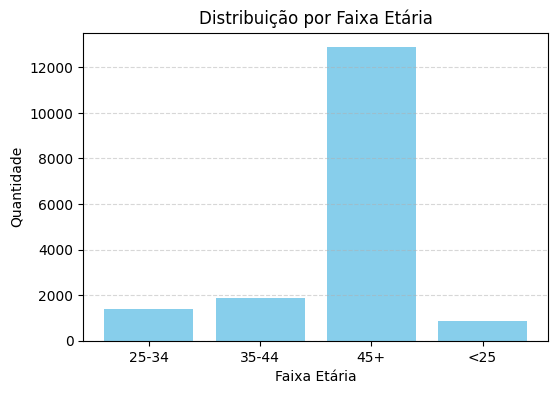

In [8]:
import matplotlib.pyplot as plt

# Agrupar por faixa etária
df_faixa = df_profile.withColumn(
    "faixa_etaria",
    F.when(F.col("age") < 25, "<25")
     .when((F.col("age") < 35), "25-34")
     .when((F.col("age") < 45), "35-44")
     .otherwise("45+")
).groupBy("faixa_etaria").count().orderBy("faixa_etaria")

# Coletar e plotar
pd_faixa = df_faixa.toPandas()

plt.figure(figsize=(6,4))
plt.bar(pd_faixa["faixa_etaria"], pd_faixa["count"], color='skyblue')
plt.title("Distribuição por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Quantidade")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

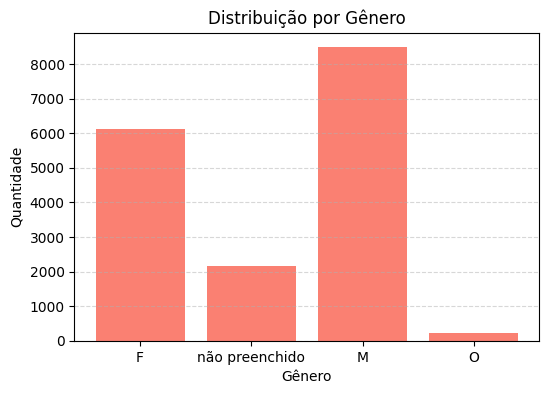

In [9]:
# Agrupar por gênero
df_genero = df_profile.groupBy("gender").count()
df_genero=df_genero.fillna('não preenchido')
# Coletar e plotar
pd_genero = df_genero.toPandas()

plt.figure(figsize=(6,4))
plt.bar(pd_genero["gender"], pd_genero["count"], color='salmon')
plt.title("Distribuição por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Quantidade")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


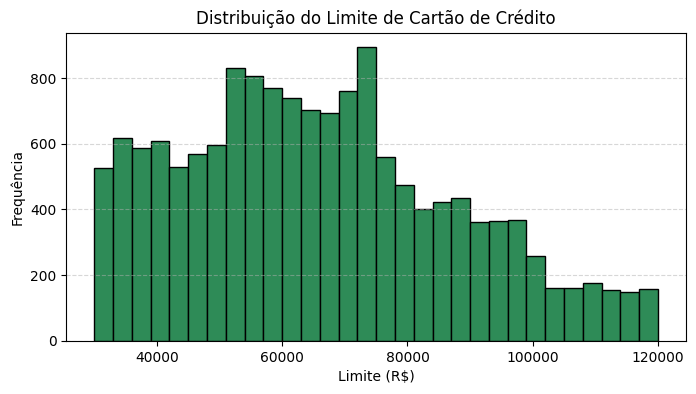

In [10]:
# Coletar coluna numérica
pd_limite = df_profile.select("credit_card_limit").dropna().toPandas()

plt.figure(figsize=(8,4))
plt.hist(pd_limite["credit_card_limit"], bins=30, color='seagreen', edgecolor='black')
plt.title("Distribuição do Limite de Cartão de Crédito")
plt.xlabel("Limite (R$)")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [11]:
df_transactions.printSchema()
df_transactions.show(5)

# Contagem de eventos
df_transactions.groupBy("event").count().orderBy("count", ascending=False).show()

# Campos dentro do struct `value`
df_transactions.select("value.amount", "value.reward", "value.offer_id").describe().show()

# Verificar quantos eventos têm valor associado
df_transactions.select(
    F.count(F.when(F.col("value.amount").isNotNull(), True)).alias("com_amount"),
    F.count(F.when(F.col("value.reward").isNotNull(), True)).alias("com_reward"),
    F.count(F.when(F.col("value.offer_id").isNotNull(), True)).alias("com_offer_id")
).show()

# Tempo desde início do teste
df_transactions.select("time_since_test_start").describe().show()


root
 |-- account_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- time_since_test_start: double (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- offer id: string (nullable = true)
 |    |-- offer_id: string (nullable = true)
 |    |-- reward: double (nullable = true)
 |-- source_file: string (nullable = false)



+--------------------+--------------+---------------------+--------------------+-----------------+
|          account_id|         event|time_since_test_start|               value|      source_file|
+--------------------+--------------+---------------------+--------------------+-----------------+
|78afa995795e4d85b...|offer received|                  0.0|{NULL, 9b98b8c7a3...|transactions.json|
|a03223e636434f42a...|offer received|                  0.0|{NULL, 0b1e1539f2...|transactions.json|
|e2127556f4f64592b...|offer received|                  0.0|{NULL, 2906b810c7...|transactions.json|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|{NULL, fafdcd668e...|transactions.json|
|68617ca6246f4fbc8...|offer received|                  0.0|{NULL, 4d5c57ea9a...|transactions.json|
+--------------------+--------------+---------------------+--------------------+-----------------+
only showing top 5 rows



+---------------+------+
|          event| count|
+---------------+------+
|    transaction|138953|
| offer received| 76277|
|   offer viewed| 57725|
|offer completed| 33579|
+---------------+------+



+-------+------------------+------------------+--------------------+
|summary|            amount|            reward|            offer_id|
+-------+------------------+------------------+--------------------+
|  count|            138953|             33579|               33579|
|   mean| 12.77735615639814| 4.904136513892611|                NULL|
| stddev|30.250528632017126|2.8866468823372804|                NULL|
|    min|              0.05|               2.0|0b1e1539f2cc45b7b...|
|    max|           1062.28|              10.0|fafdcd668e3743c1b...|
+-------+------------------+------------------+--------------------+



+----------+----------+------------+
|com_amount|com_reward|com_offer_id|
+----------+----------+------------+
|    138953|     33579|       33579|
+----------+----------+------------+



+-------+---------------------+
|summary|time_since_test_start|
+-------+---------------------+
|  count|               306534|
|   mean|   15.265955815668082|
| stddev|    8.346929730115084|
|    min|                  0.0|
|    max|                29.75|
+-------+---------------------+



In [12]:
df_offers.printSchema()
df_offers.show(5)

# Contagem total
print(f"Total de ofertas: {df_offers.count()}")

# Tipos de oferta
df_offers.groupBy("offer_type").count().show()

# Descontos e valores mínimos
df_offers.select("discount_value", "min_value", "duration").describe().show()

# Canais utilizados
df_offers.select(F.explode("channels").alias("channel")).groupBy("channel").count().show()


root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- source_file: string (nullable = false)

+--------------------+--------------+--------+--------------------+---------+-------------+-----------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|source_file|
+--------------------+--------------+--------+--------------------+---------+-------------+-----------+
|[email, mobile, s...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|offers.json|
|[web, email, mobi...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|offers.json|
|[web, email, mobile]|             0|     4.0|3f207df678b143eea...|        0|informational|offers.json|
|[web, email, mobile]|             5|   

## Transformação de Tabelas

### Desaninhamento de JSON

In [13]:


print('Antes:', df_transactions.count())

# Acesse diretamente os campos da coluna STRUCT 'value'
df_transactions = df_transactions.select("*", 
    col("value.amount").alias("amount"),
    col("value.offer_id").alias("offer_id"),
    col("value.offer id").alias("offer id"),
    col("value.reward").alias("reward")
)

print(f'Depois de desaninhar Json da coluna value: {df_transactions.count()}')

# Retirar coluna desaninhada
df_transactions=df_transactions.drop("value")

Antes: 306534
Depois de desaninhar Json da coluna value: 306534


Podemos ver que desaninhar não alterou o número de linhas

### Conversão de arrays em colunas

In [14]:


#  Explode os valores da lista para identificar os valores únicos
unique_channels = df_offers.select(explode(col("channels")).alias("channel")) \
                                  .distinct() \
                                  .rdd.flatMap(lambda row: row) \
                                  .collect()

#  Para cada valor possível, cria uma nova coluna binária (1 se presente, 0 se não)
for ch in unique_channels:
    df_offers = df_offers.withColumn(
        f"channel_{ch}",
        when(array_contains(col("channels"), ch), lit(1)).otherwise(lit(0))
    )
df_offers=df_offers.drop("channels")

## Manipulação e Limpeza dos Dados

### Remover linhas duplicadas

In [15]:
def verificar_duplicatas(df, nome_df="DataFrame"):
    total = df.count()
    distintos = df.distinct().count()
    duplicadas = total - distintos
    print(f"\n {nome_df}:")
    print(f" - Total de linhas: {total}")
    print(f" - Linhas distintas: {distintos}")
    print(f" - Linhas duplicadas: {duplicadas}")

verificar_duplicatas(df_transactions, "df_transactions")
verificar_duplicatas(df_offers, "df_offers")
verificar_duplicatas(df_profile, "df_profile")


 df_transactions:
 - Total de linhas: 306534
 - Linhas distintas: 306137
 - Linhas duplicadas: 397



 df_offers:
 - Total de linhas: 10
 - Linhas distintas: 10
 - Linhas duplicadas: 0

 df_profile:
 - Total de linhas: 17000
 - Linhas distintas: 17000
 - Linhas duplicadas: 0


Como temos uma série histórica de eventos sem id por evento (a tabela transactions não tem id) e temos apenas o tempo (time_since_test_start), o tipo de evento e o id da conta como referência, não conseguimos identificar se um evento de fato esta duplicado na tabela. Porem, como verificamos que apenas 0,13% da base esta duplicada, acredito que não será significante na nossa base. Por isso vamos excluir.

In [16]:
df_transactions = df_transactions.dropDuplicates()
df_offers = df_offers.dropDuplicates()
df_profile = df_profile.dropDuplicates()

verificar_duplicatas(df_transactions, "df_transactions")
verificar_duplicatas(df_offers, "df_offers")
verificar_duplicatas(df_profile, "df_profile")



 df_transactions:
 - Total de linhas: 306137
 - Linhas distintas: 306137
 - Linhas duplicadas: 0

 df_offers:
 - Total de linhas: 10
 - Linhas distintas: 10
 - Linhas duplicadas: 0

 df_profile:
 - Total de linhas: 17000
 - Linhas distintas: 17000
 - Linhas duplicadas: 0


### Identificar colunas duplicadas

In [17]:
display(df_transactions.describe())

DataFrame[summary: string, account_id: string, event: string, time_since_test_start: string, source_file: string, amount: string, offer_id: string, offer id: string, reward: string]

In [18]:
# Como offer id e offer_id aparentemente são colunas que se complementam vamos testar se isso é verdade: quando ambas são não nulas se não temos divergência de valores

# Filtra linhas em que ambas as colunas são não nulas e diferentes
df_diff = df_transactions.filter(
    col("offer id").isNotNull() & 
    col("offer_id").isNotNull() & 
    (col("offer id") != col("offer_id"))
)

# Conta essas linhas
diff_count = df_diff.count()
print(f"Número de linhas com 'offer id' diferente de 'offer_id': {diff_count}")


Número de linhas com 'offer id' diferente de 'offer_id': 0


In [19]:
display(df_profile.describe())

DataFrame[summary: string, age: string, credit_card_limit: string, gender: string, id: string, registered_on: string, source_file: string]

In [20]:
display(df_offers.describe())

DataFrame[summary: string, discount_value: string, duration: string, id: string, min_value: string, offer_type: string, source_file: string, channel_mobile: string, channel_email: string, channel_social: string, channel_web: string]

Apenas olhandos o mínimo e máximo de cada coluna podemos ver que não temos possíveis colunas duplicadas.
 Se fossem iguais poderiamos testar se realmente são iguais,mas não precisamos.

### Tratamento de valores nulos 

#### Verificação de valores nulos

In [21]:


def check_nulls(df, df_name="DataFrame"):
    print(f"\n>>> Verificando nulos em: {df_name}")
    nulls_df = df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ])
    nulls_df.show()

dfs = {
    "df_profile": df_profile,
    "df_transactions": df_transactions,
    "df_offers": df_offers
}

for name, df in dfs.items():
    check_nulls(df, name)



>>> Verificando nulos em: df_profile
+---+-----------------+------+---+-------------+-----------+
|age|credit_card_limit|gender| id|registered_on|source_file|
+---+-----------------+------+---+-------------+-----------+
|  0|             2175|  2175|  0|            0|          0|
+---+-----------------+------+---+-------------+-----------+


>>> Verificando nulos em: df_transactions


+----------+-----+---------------------+-----------+------+--------+--------+------+
|account_id|event|time_since_test_start|source_file|amount|offer_id|offer id|reward|
+----------+-----+---------------------+-----------+------+--------+--------+------+
|         0|    0|                    0|          0|167184|  272955|  172135|272955|
+----------+-----+---------------------+-----------+------+--------+--------+------+


>>> Verificando nulos em: df_offers
+--------------+--------+---+---------+----------+-----------+--------------+-------------+--------------+-----------+
|discount_value|duration| id|min_value|offer_type|source_file|channel_mobile|channel_email|channel_social|channel_web|
+--------------+--------+---+---------+----------+-----------+--------------+-------------+--------------+-----------+
|             0|       0|  0|        0|         0|          0|             0|            0|             0|          0|
+--------------+--------+---+---------+----------+-----------

#### Imputação de valores nulos em numéricos

In [22]:


# Verificando a hipótese de que os valores nulos são na verdade zero nas colunas numéricas
print("Tipos das colunas:")
print("df_profile:")
df_profile.select("credit_card_limit").printSchema()

print("df_transactions:")
df_transactions.select("amount", "reward").printSchema()

# Contando valores zero
zero_credit_card_limit = df_profile.filter(col("credit_card_limit") == 0).count()
print(f"\nNúmero de registros com credit_card_limit = 0: {zero_credit_card_limit}")

zero_amount = df_transactions.filter(col("amount") == 0).count()
print(f"Número de registros com amount = 0: {zero_amount}")

zero_reward = df_transactions.filter(col("reward") == 0).count()
print(f"Número de registros com reward = 0: {zero_reward}")


Tipos das colunas:
df_profile:
root
 |-- credit_card_limit: double (nullable = true)

df_transactions:
root
 |-- amount: double (nullable = true)
 |-- reward: double (nullable = true)


Número de registros com credit_card_limit = 0: 0


Número de registros com amount = 0: 0


Número de registros com reward = 0: 0


In [23]:
# Como não temos valor zero para as três colunas numéricas com dados faltantes (reward,amount e credit_card_limit), faz sentido supor que quando são nulas são zero, logo vamos inputar como zero esses dados. Para não perder informação vamos criar colunas informando quando elas foram nulas.


# Para a tabela df_profile
df_profile = df_profile.withColumn(
    "credit_card_limit_is_null", 
    when(col("credit_card_limit").isNull(), 1).otherwise(0)
).fillna({"credit_card_limit": 0})  # Preenche os nulos de credit_card_limit com 0

# Para a tabela df_transactions
df_transactions = df_transactions.withColumn(
    "amount_is_null", 
    when(col("amount").isNull(), 1).otherwise(0)
).withColumn(
    "reward_is_null", 
    when(col("reward").isNull(), 1).otherwise(0)
).fillna({"amount": 0, "reward": 0})  # Preenche os nulos de amount e reward com 0


#### Imputação de valores nulos com coluna auxiliar

In [24]:


# Como vimos que 'offer id' e 'offer_id' se complementam e não contem divergência de dados vamos unificá-las
# Atualiza 'offer_id' com valor de 'offer id' se for null
df_transactions = df_transactions.withColumn(
    "offer_id",
    when(col("offer_id").isNull(), col("offer id")).otherwise(col("offer_id"))
)

# Remove a coluna com dados duplicados
df_transactions = df_transactions.drop("offer id")

#### Imputação de valores nulos categóricos

In [25]:
df_profile=df_profile.fillna({
    "gender": "nao_preenchido"
})


### Remoção de colunas irrelevantes

In [26]:
#vamos também remover as colunas source que não adicionam valor a nossa análise por ter sempre o mesmo valor e dizer apenas o nome da tabela. Isso vai melhorar a organização da tabela para não ter colunas com nomes duplicados
df_transactions=df_transactions.drop("source_file")
df_offers=df_offers.drop("source_file")
df_profile=df_profile.drop("source_file")

### Remoção de Outliers

In [27]:


def remover_outliers(df, nome_df="df"):
    print(f"\nRemovendo outliers em: {nome_df}")
    numeric_cols = [f.name for f in df.schema.fields if str(f.dataType) in ('IntegerType', 'DoubleType', 'LongType', 'FloatType')]
    original_count = df.count()
    df_filtrado = df

    for col_name in numeric_cols:
        quantiles = df_filtrado.approxQuantile(col_name, [0.25, 0.75], 0.01)
        if len(quantiles) < 2:
            continue

        q1, q3 = quantiles
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df_filtrado = df_filtrado.filter((col(col_name) >= lower) & (col(col_name) <= upper))

    final_count = df_filtrado.count()
    total_removed = original_count - final_count

    print(f"{total_removed} linhas removidas por outliers em {nome_df}")
    print(f"Total final de linhas: {final_count}")
    return df_filtrado

# Aplicando a função nos três datasets
df_transactions = remover_outliers(df_transactions, "df_transactions")
df_offers = remover_outliers(df_offers, "df_offers")
df_profile = remover_outliers(df_profile, "df_profile")


Removendo outliers em: df_transactions


0 linhas removidas por outliers em df_transactions
Total final de linhas: 306137

Removendo outliers em: df_offers
0 linhas removidas por outliers em df_offers
Total final de linhas: 10

Removendo outliers em: df_profile
0 linhas removidas por outliers em df_profile
Total final de linhas: 17000


## Preparação do Dataset Unificado

#### Junção de múltiplas tabelas (joins)

In [28]:
# Faz o LEFT JOIN entre transações e perfis e remover colunas de ids duplicados.
print('Total de linhas Antes:',df_transactions.count())
df_joined = df_transactions.join(df_profile, df_transactions.account_id == df_profile.id, how="left")
df_joined=df_joined.drop("id")
df_joined = df_joined.join(df_offers, df_joined.offer_id == df_offers.id, how="left")
df_joined=df_joined.drop("id")
print('Total de linhas depois:',df_joined.count())

Total de linhas Antes: 306137


Total de linhas depois: 306137


#### Checagem de integridade após merge

In [29]:


def contar_nulos(df, nome_df="DataFrame"):
    print(f"\nValores nulos no {nome_df}:\n")
    display(df.select([
        spark_sum(
            when(col(c).isNull(), 1).otherwise(0)
        ).alias(c) for c in df.columns
    ]))

# Exemplo para df_joined
contar_nulos(df_joined, "df_joined")


Valores nulos no df_joined:



DataFrame[account_id: bigint, event: bigint, time_since_test_start: bigint, amount: bigint, offer_id: bigint, reward: bigint, amount_is_null: bigint, reward_is_null: bigint, age: bigint, credit_card_limit: bigint, gender: bigint, registered_on: bigint, credit_card_limit_is_null: bigint, discount_value: bigint, duration: bigint, min_value: bigint, offer_type: bigint, channel_mobile: bigint, channel_email: bigint, channel_social: bigint, channel_web: bigint]

#### Ajuste de Nulos Pós Merge

In [30]:
# Como na tabela transactions haviam offer_id nulos vamos prencher esses valores com zero, ou seja não houve oferta e vamos criar uma coluna para identificar quando não houve oferta.


#  Criar coluna binária indicando se offer_id é nulo
df_joined = df_joined.withColumn("is_offer_id_null", when(col("offer_id").isNull(), 1).otherwise(0))

#  Lista de colunas para preencher nulos com zero
colunas_para_preencher = [
    "offer_id", "discount_value", "duration", "min_value",
    "channel_mobile", "channel_email", "channel_social", "channel_web"
]

#  Substituir nulos por 0 nessas colunas
for coluna in colunas_para_preencher:
    df_joined = df_joined.withColumn(coluna, when(col(coluna).isNull(), 0).otherwise(col(coluna)))

## Engenharia de Variáveis

### Transformar Data em tempo

In [31]:


# Vamos criar a coluna de data para tempo para o modelo conseguir interpretar 

#  Converter 'registered_on' para data no formato yyyyMMdd
df_joined = df_joined.withColumn("registered_on_date", to_date(col("registered_on").cast("string"), "yyyyMMdd"))

#  Obter a data mais recente da coluna 'registered_on_date'
max_data = df_joined.agg(spark_max("registered_on_date").alias("max_date")).collect()[0]["max_date"]

# Criar nova coluna com diferença em dias até a data mais recente
df_joined = df_joined.withColumn("dias_desde_registro", datediff(lit(max_data), col("registered_on_date")))

### Extração de features

#### Criação de variáveis temporais derivadas

In [32]:


# Criar colunas de ano, mês e semana
df_joined = df_joined \
    .withColumn("ano_registro", year(col("registered_on_date"))) \
    .withColumn("mes_registro", month(col("registered_on_date"))) \
    .withColumn("semana_registro", weekofyear(col("registered_on_date")))

# Remover coluna antiga
df_joined = df_joined.drop("registered_on")

## Reformatação da Tabela

In [33]:

#  Filtrar ofertas recebidas
offers_received = df_joined.filter(col("event") == "offer received")

#  Adicionar janela de duração da oferta
offers_received = offers_received.withColumn("offer_window_end", col("time_since_test_start") + col("duration"))

#  Transações
transactions = df_joined.filter(col("event") == "transaction") \
    .select("account_id", "time_since_test_start") \
    .withColumnRenamed("time_since_test_start", "transaction_time")

#  Verificar se houve transação no intervalo da oferta
joined = offers_received.join(
    transactions,
    on="account_id",
    how="left"
).filter(
    (col("transaction_time") >= col("time_since_test_start")) &
    (col("transaction_time") <= col("offer_window_end"))
)

#  Marcar conversões
converted = joined.groupBy("account_id", "offer_id", "time_since_test_start") \
    .agg(spark_max(lit(1)).alias("converted"))

#  Preencher 0 para quem não converteu
offers = offers_received.join(
    converted,
    on=["account_id", "offer_id", "time_since_test_start"],
    how="left"
).withColumn("converted", when(col("converted").isNull(), 0).otherwise(1))

## Salvamento

### Salvar em Parquet

In [34]:
    # Caminho para salvar os dados processados
    processed_data_path = os.path.join(project_root, "data", "processed")

    # Cria a pasta se não existir
    os.makedirs(processed_data_path, exist_ok=True)

    # Caminho completo do arquivo Parquet
    parquet_output_path_transformed = os.path.join(processed_data_path, "unificado_transformed.parquet")
    parquet_output_path = os.path.join(processed_data_path, "unificado.parquet")

    # Salva como Parquet
    print(f"Salvando dados em: {parquet_output_path_transformed}")
    offers.write.mode("overwrite").parquet(parquet_output_path_transformed)
    print(f"Salvando dados em: {parquet_output_path}")
    df_joined.write.mode("overwrite").parquet(parquet_output_path)
    print("Dados salvos com sucesso.")


Salvando dados em: /workspaces/ifood-case/data/processed/unificado_transformed.parquet


25/04/17 18:45:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Salvando dados em: /workspaces/ifood-case/data/processed/unificado.parquet


Dados salvos com sucesso.
